In [12]:
# set module auto-reloaded 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Load MNIST data set

from tensorflow.keras.datasets import mnist
train_set, test_set = mnist.load_data()

In [14]:
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, BatchNormalization, ReLU
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
import numpy as np
import dahuffman
import pickle
from Compressible_Huffman import Huffman
from regularization import *
from getModel import get_simplemodel

# generate a simple NN model
model = get_simplemodel()

In [15]:
from regularization import calculate_histogram, test_histogram, calculate_histogram_range, calculate_entropy, calc_sparsity_regularization, nbins
class CompressibleNN(keras.Model):
    def __init__(self, net_model):
        super(CompressibleNN, self).__init__()
        self.net_model = net_model
        self.CE_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    def call(self, inputs):
        return self.net_model(inputs)
    
    def entropy_loss(self, inputs, regularization_weighting_coefficient = 1.0):
        entropy = 0
        
        for l in self.net_model.layers:
            if isinstance(l, keras.layers.Dense):
                for v in l.trainable_variables:
                    v_entropy, v_range = calculate_entropy(v)
                    entropy += v_entropy
        entropy = entropy * regularization_weighting_coefficient / tf.experimental.numpy.log2(tf.cast(nbins, tf.float32))
        return entropy
    
    def regularization_loss(self, inputs, regularization_weighting_coefficient = 1e-2):
        rg_loss = 0
        num_activations = 0  # Initialize the total number of activations
        
        for l in self.net_model.layers:
            if isinstance(l, keras.layers.Dense):
                for v in l.trainable_variables:
                    num_activations += tf.reduce_prod(v.shape)  # Accumulate the number of activations
                    v_regularization_loss = calc_sparsity_regularization(v)
                    rg_loss += v_regularization_loss

        # Divide the total regularization loss by the total number of activations
        rg_loss = rg_loss * regularization_weighting_coefficient / tf.cast(num_activations, dtype=tf.float32)
        
        return rg_loss
    
    
    def train_step(self, input):
        images = input[0]
        labels = input[1]

        with tf.GradientTape() as tape:
            output = self.net_model(images)
            loss =  self.entropy_loss(images)
            regularization_loss = self.regularization_loss(images)

        # 1. Entropy-based regularization
        # Get the gradients w.r.t the loss
        gradient = tape.gradient(loss, self.net_model.trainable_variables)
        # Update the weights using the generator optimizer
        self.optimizer.apply_gradients(
            zip(gradient, self.net_model.trainable_variables)
        )
        return {"loss": loss}

        # 2. Sparsity-based regularization
#         gradient_reg = tape.gradient(regularization_loss, self.net_model.trainable_variables)
#         # Update the weights using the generator optimizer
#         self.optimizer.apply_gradients(
#             zip(gradient_reg, self.net_model.trainable_variables)
#         )
#         return {"regularization loss": regularization_loss}

In [16]:
compressibleNN = CompressibleNN(model)
optimizer = tf.optimizers.Adam(learning_rate=1e-3, beta_1=0.9)
compressibleNN.compile(optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [17]:
original_weights = compressibleNN.net_model.get_weights()

# Save the original weights
with open('original_model_weights.pkl', 'wb') as file:
    pickle.dump(original_weights, file)

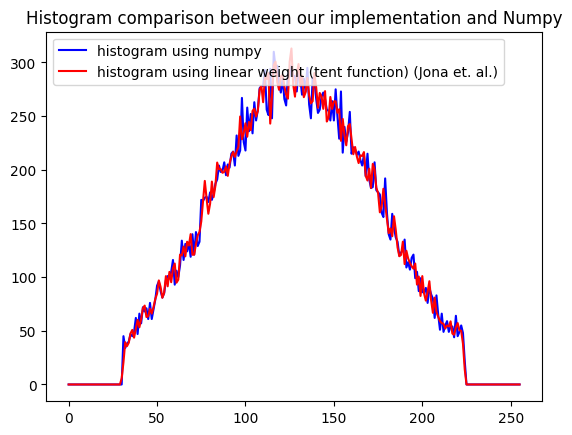

In [18]:
from regularization import visualize_histogram
variables=model.layers[3].variables[0]
visualize_histogram(variables)

In [19]:
# train the model
tf.config.run_functions_eagerly(True)
# loss needs to be decreased during training
compressibleNN.fit(x=train_set[0], y=train_set[1], epochs=1, batch_size=256)

235/235 [==============================] - 323s 1s/step - loss: 2.9624


In [20]:
# Compression process
# compNN.weights
trainedNN = Huffman(compressibleNN)
compressed_weights = trainedNN.compressNN()

# set compNN.weights to 0
for layer in trainedNN.net_model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        layer.set_weights([tf.zeros_like(w) for w in layer.get_weights()])


In [34]:
compressibleNN.save("trainedNN")

ValueError: Model <__main__.CompressibleNN object at 0xffff1a3d5570> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

In [32]:
compressibleNN.save('trainedNN',save_format='tf')

ValueError: Model <__main__.CompressibleNN object at 0xffff1a3d5570> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

In [28]:
compressibleNN.save('trainedNN')

ValueError: Model <__main__.CompressibleNN object at 0xffff1a3d5570> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

In [25]:
# Save the CompressibleNN instance to a file
with open('compressed_nn_new.pkl', 'wb') as outp:  # Overwrites any existing file.
#     pickle.dump(trainedNN.net_model, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(trainedNN.codec, outp, pickle.HIGHEST_PROTOCOL)
    pickle.dump(compressed_weights, outp, pickle.HIGHEST_PROTOCOL)

TypeError: cannot pickle 'weakref.ReferenceType' object

In [ ]:
import os
file_path = r'compressed_nn_new_weights.pkl'

sz = os.path.getsize(file_path)
print(f'The {file_path} size is', sz, 'bytes')

In [ ]:
# test performance
res = trainedNN(test_set[0])
print("test acc: ", 100*(np.argmax(res, axis=1)==test_set[1]).mean())